DS300 Final Project Group 1 

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns


url = 'https://raw.githubusercontent.com/steelab/Data-Privacy-in-Insurance/main/insurance.csv'
df = pd.read_csv(url)
df


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [2]:
#mapping certain variables to numerical values
df['sex']= df['sex'].map({'male':0,'female':1})
df['smoker']= df['smoker'].map({'yes':1,'no':0})

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520


0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64


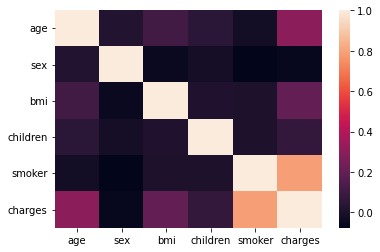

In [3]:
print(df.children.value_counts())
sns.heatmap(df.corr());


In [4]:
#changing the data type of the variables in our dataset to categorical 
categorical = set((
    'sex',
    'smoker',
    'region',
))
for name in categorical:
    df[name] = df[name].astype('category')
df.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

Implement a function that returns the spans (max-min for numerical columns, number of different values for categorical columns) of all columns for a partition of a dataframe.   More info on spans https://pypi.org/project/Spans/




In [5]:

def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans


In [6]:
full_spans = get_spans(df, df.index)
full_spans

{'age': 46,
 'sex': 2,
 'bmi': 37.17,
 'children': 5,
 'smoker': 2,
 'region': 4,
 'charges': 62648.554110000005}

Implement a split function that takes a dataframe, partition and column and returns two partitions that split the given partition such that all rows with values of the column column below the median are in one partition and all rows with values above or equal to the median are in the other.



In [7]:
def split(df, partition, column): ## divides values by median 
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

In [8]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

In [9]:
# we apply our partitioning method to three columns of our dataset, using "charges" as the sensitive attribute
feature_columns = ['age', 'bmi', 'children']
sensitive_column = 'charges'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

# we get the number of partitions that were created
len(finished_partitions)

347

In [10]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [11]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [12]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [57]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column

    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break

        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
       
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        # values = grouped_columns.iloc[0].to_dict()   #ERROR HERE
        values = grouped_columns.iloc[0:3].to_dict()
        for i in values:
          conv_val = values[i]
          s = [str(integer) for integer in conv_val]
          a_string = "".join(s)
          res = round(float(a_string),2)
          values[i] = res
        print(values)
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)
print(dfn)

{'age': 18.0, 'bmi': 28.63, 'children': 0.0}
Finished 1 partitions...
{'age': 19.11, 'bmi': 32.16, 'children': 0.0}
{'age': 18.0, 'bmi': 34.72, 'children': 0.0}
{'age': 18.75, 'bmi': 17.46, 'children': 0.0}
{'age': 20.4, 'bmi': 19.89, 'children': 0.0}
{'age': 18.0, 'bmi': 21.37, 'children': 0.0}
{'age': 19.2, 'bmi': 21.31, 'children': 0.0}
{'age': 18.0, 'bmi': 23.09, 'children': 0.0}
{'age': 18.0, 'bmi': 24.67, 'children': 0.0}
{'age': 18.25, 'bmi': 25.86, 'children': 0.0}
{'age': 18.8, 'bmi': 27.55, 'children': 0.0}
{'age': 20.6, 'bmi': 26.88, 'children': 0.0}
{'age': 22.4, 'bmi': 27.3, 'children': 0.0}
{'age': 25.33, 'bmi': 19.66, 'children': 0.0}
{'age': 25.0, 'bmi': 22.66, 'children': 0.0}
{'age': 24.5, 'bmi': 23.66, 'children': 0.0}
{'age': 24.25, 'bmi': 25.26, 'children': 0.0}
{'age': 28.0, 'bmi': 21.32, 'children': 0.0}
{'age': 27.8, 'bmi': 25.06, 'children': 0.0}
{'age': 24.5, 'bmi': 26.99, 'children': 0.0}
{'age': 24.25, 'bmi': 28.53, 'children': 0.0}
{'age': 28.0, 'bmi': 26.4

In [62]:
feature_columns

['age', 'bmi', 'children']

In [63]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

{'age': 18.0, 'bmi': 28.63, 'children': 0.0}
Finished 1 partitions...
{'age': 19.11, 'bmi': 32.16, 'children': 0.0}
{'age': 18.0, 'bmi': 34.72, 'children': 0.0}
{'age': 18.75, 'bmi': 17.46, 'children': 0.0}
{'age': 20.4, 'bmi': 19.89, 'children': 0.0}
{'age': 18.0, 'bmi': 21.37, 'children': 0.0}
{'age': 19.2, 'bmi': 21.31, 'children': 0.0}
{'age': 18.0, 'bmi': 23.09, 'children': 0.0}
{'age': 18.0, 'bmi': 24.67, 'children': 0.0}
{'age': 18.25, 'bmi': 25.86, 'children': 0.0}
{'age': 18.8, 'bmi': 27.55, 'children': 0.0}
{'age': 20.6, 'bmi': 26.88, 'children': 0.0}
{'age': 22.4, 'bmi': 27.3, 'children': 0.0}
{'age': 25.33, 'bmi': 19.66, 'children': 0.0}
{'age': 25.0, 'bmi': 22.66, 'children': 0.0}
{'age': 24.5, 'bmi': 23.66, 'children': 0.0}
{'age': 24.25, 'bmi': 25.26, 'children': 0.0}
{'age': 28.0, 'bmi': 21.32, 'children': 0.0}
{'age': 27.8, 'bmi': 25.06, 'children': 0.0}
{'age': 24.5, 'bmi': 26.99, 'children': 0.0}
{'age': 24.25, 'bmi': 28.53, 'children': 0.0}
{'age': 28.0, 'bmi': 26.4

In [64]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
dfn.sort_values(feature_columns+[sensitive_column])

,age,bmi,children,charges,count
24,18.00,21.37,0.0,1607.51010,1
25,18.00,21.37,0.0,1702.45530,1
26,18.00,21.37,0.0,13747.87235,1
27,18.00,21.37,0.0,14283.45940,1
33,18.00,23.09,0.0,1121.87390,1
...,...,...,...,...,...
978,63.33,27.20,0.0,29330.98315,1
979,63.33,27.20,0.0,29523.16560,1
1327,63.67,31.78,2.0,16069.08475,1
1328,63.67,31.78,2.0,47291.05500,1


In [65]:
df.region.value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64